In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import matthews_corrcoef, accuracy_score
from typing import Callable, Dict

def cross_validate_treeg(
    clf_class,
    X,
    y,
    param_grid: Dict[str, list],
    cv: int = 3,
    scoring: Callable = matthews_corrcoef,
    stratified: bool = True,
    random_state: int = 42
):
    """
    Generic cross-validation for TREE-G classifiers using pandas for grid.
    Returns the best params and a sorted DataFrame of all results.
    Prints progress during evaluation.
    """
    results = []

    # Create a DataFrame of all hyperparameter combinations
    grid_df = pd.DataFrame(
        pd.MultiIndex.from_product(
            param_grid.values(),
            names=param_grid.keys()
        ).to_list(),
        columns=param_grid.keys()
    )


    # Choose CV splitter
    kf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state) if stratified else KFold(n_splits=cv, shuffle=True, random_state=random_state)

    total_combinations = len(grid_df)
    comb_index = 0

    # Iterate over each combination
    for params in grid_df.to_dict(orient='records'):
        comb_index += 1
        fold_scores = []

        print(f"\nEvaluating combination {comb_index}/{total_combinations}: {params}")

        for fold_idx, (train_idx, test_idx) in enumerate(kf.split(X, y), 1):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            clf = clf_class(**params)
            clf.fit(X_train, y_train)

            y_pred = clf.predict(X_test)
            score = scoring(y_test, y_pred)
            fold_scores.append(score)

            print(f"  Fold {fold_idx}/{cv}: score = {score:.4f}")

        mean_score = np.mean(fold_scores)
        print(f"  Mean score for combination: {mean_score:.4f}")
        results.append({**params, "mean_score": mean_score})

    # Create a DataFrame of results and sort descending
    results_df = pd.DataFrame(results).sort_values(by="mean_score", ascending=False).reset_index(drop=True)

    best_params = results_df.iloc[0].drop("mean_score").to_dict()
    best_score = results_df.iloc[0]["mean_score"]

    return best_params, best_score, results_df


In [17]:
from treeg.graph_treeg.data_formetter_graph_level import DataFormatter
from treeg.graph_treeg.graph_data_graph_level import GraphData
from ensembels.gbdt.treeg_gbdt import GradientBoostedGraphTreeGClassifier
from experiments import datasets

dataset = datasets.TU_MUTAG()
formatter = DataFormatter(GraphData)
X, y = formatter.pyg_data_list_to_tree_graph_data_list(dataset)
X, y = np.array(X), np.array(y)

param_grid = {
    # Boosting / learning
    "n_estimators": [20],
    "learning_rate": [0.01, 0.1], # explore smaller and medium rates

    # Graph walk / tree complexity
    "max_walk_len": [5, 10, 15],         # longer walks = higher capacity
    "attention_set_limit": [1, 2],    # allow more nodes to attend
    # "min_samples_split": [2, 5, 10],     # splits control overfitting
    "min_samples_leaf": [2, 4],       # small leaves allow more granular trees

    # Optional regularization
    "max_leaf_nodes": [None]    # cap leaves for regularization
}


best_params, best_score, results_df = cross_validate_treeg(
    GradientBoostedGraphTreeGClassifier,
    X, y,
    param_grid=param_grid,
    cv=3,
    scoring=matthews_corrcoef
)

print("Best MCC:", best_score)
print("Best parameters:", best_params)
print("\nAll results sorted:\n", results_df)


KeyboardInterrupt: 

In [17]:
print(clf)


In [38]:
import numpy as np

feature_importance = clf.feature_importances_
print('feature_importance: ' + str(feature_importance))

feature_importance: [0.485963   0.275961   0.17986291 0.         0.         0.05821309
 0.        ]


In [41]:
print(dataset[0])            # Show the first graph's info


Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


In [46]:
def traverse_tree_full(node, depth=0):
    indent = "  " * depth
    # Gather key attributes safely
    active_idx = getattr(node, 'active_attention_index', None)
    aggregator = getattr(node, 'aggregator', None)
    attention_type = getattr(node, 'attention_type', None)
    feature_idx = getattr(node, 'feature_index', None)
    gain = getattr(node, 'gain', None)
    thresh = getattr(node, 'thresh', None)
    tree_depth = getattr(node, 'tree_depth', None)
    node_count = getattr(node, 'node_count', None)
    value_leaf = getattr(node, 'value_as_leaf', None)
    walk_len = getattr(node, 'walk_len', None)

    print(f"{indent}Node depth {depth}:")
    print(f"{indent}  active_attention_index: {active_idx}")
    print(f"{indent}  aggregator: {aggregator}")
    print(f"{indent}  attention_type: {attention_type}")
    print(f"{indent}  feature_index: {feature_idx}")
    print(f"{indent}  gain: {gain}")
    print(f"{indent}  thresh: {thresh}")
    print(f"{indent}  tree_depth: {tree_depth}")
    print(f"{indent}  node_count: {node_count}")
    print(f"{indent}  value_as_leaf: {value_leaf}")
    print(f"{indent}  walk_len: {walk_len}")
    print()

    # Recurse left (lte)
    if hasattr(node, 'lte') and node.lte is not None:
        traverse_tree_full(node.lte, depth + 1)
    # Recurse right (gt)
    if hasattr(node, 'gt') and node.gt is not None:
        traverse_tree_full(node.gt, depth + 1)


In [48]:
root = clf.gbtreeg.estimators_[0][0].trained_tree_root_  # adjust indices if needed

# Assuming your root node is stored in variable root_node
traverse_tree_full(root)


Node depth 0:
  active_attention_index: 0
  aggregator: <treeg.graph_treeg.aggregator_graph_level.Aggregator object at 0x70aa80132d00>
  attention_type: 3
  feature_index: 0
  gain: 6.45143370310767
  thresh: 1928.3541870117188
  tree_depth: 6
  node_count: 18
  value_as_leaf: 0.02995186582327576
  walk_len: 9

  Node depth 1:
    active_attention_index: 2
    aggregator: <treeg.graph_treeg.aggregator_graph_level.Aggregator object at 0x70aa80132d30>
    attention_type: 4
    feature_index: 0
    gain: 2.1873349927738133
    thresh: 7590.0
    tree_depth: None
    node_count: None
    value_as_leaf: -0.23054674238247366
    walk_len: 10

    Node depth 2:
      active_attention_index: 0
      aggregator: <treeg.graph_treeg.aggregator_graph_level.Aggregator object at 0x70aa80132d00>
      attention_type: 4
      feature_index: 0
      gain: 2.1042358825694674
      thresh: 50.261905670166016
      tree_depth: None
      node_count: None
      value_as_leaf: -0.3205536349739696
      walk

In [37]:
X[0]

Extracting ./MUTAG/MUTAG.zip
Processing...
Done!


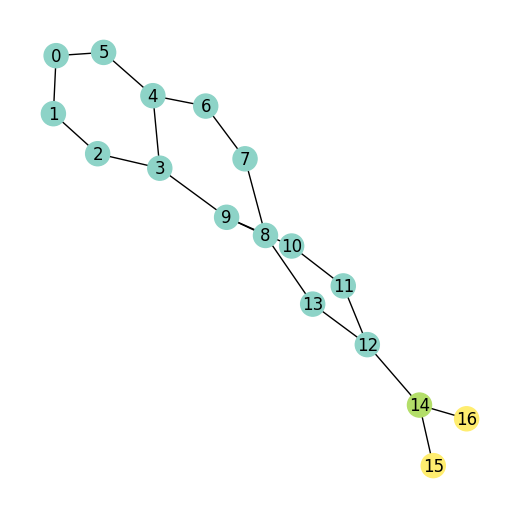

In [43]:
from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx

dataset = TUDataset(root=".", name="MUTAG")
data = dataset[0]  # first graph

G = to_networkx(data, to_undirected=True)

plt.figure(figsize=(5,5))
node_colors = data.x.argmax(dim=1) if data.x is not None else None
nx.draw(G, with_labels=True, node_color=node_colors, cmap="Set3")
plt.show()


In [49]:
print("Example graph features shape:", dataset[0].x.shape)
print("Example graph features:", dataset[0].x)


Example graph features shape: torch.Size([17, 7])
Example graph features: tensor([[1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.]])


In [50]:
from sklearn.metrics import matthews_corrcoef

# After training
y_pred = clf.predict(X_test)

# Compute MCC
mcc = matthews_corrcoef(y_test, y_pred)
print("MCC:", mcc)


MCC: 0.7548881579537979
